# 支持向量机

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mldataset as dataset

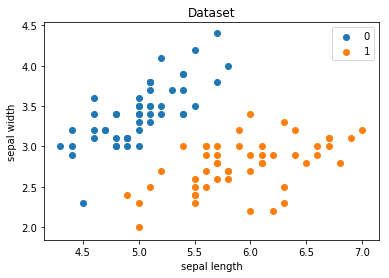

In [9]:
X, Y = dataset.iris()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [11]:
X[:,0]

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
       6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
       6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
       6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
       6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7])

In [4]:
class SVM(object):
    def __init__(self, max_iter=200, kernel="linear"):
        self.max_iter = max_iter
        self.kernel = kernel
        
    def init_args(self, X, Y):
        self.m, self.n = X.shape
        self.X = X
        self.Y = Y
        self.b = 0.0
        
        # 将Ei保存在一个列表里
        self.alpha = np.ones(self.m)   # 创建一个与元素个数对应的全为1的向量
        self.E = [self._E(i) for i in range(self.m)]  # m：样本个数   每个x的预测值与label的差值
        # 松弛变量
        self.C = 1.0
        
    def _KKT(self, i):
        '''yi*(w*xi+b)  判断是否在精度范围内满足停机条件'''
        y_g = self._g(i)*self.Y[i]    # 该样本预测值×true_label
        if self.alpha[i] == 0:
            return y_g >= 1
        elif 0 < self.alpha[i] < self.C:
            return y_g == 1
        else:
            return y_g <= 1
    
    # g(x)预测值，输入xi（X[i]）
    def _g(self, i):
        r = self.b
        for j in range(self.m):
            r += self.alpha[j]*self.Y[j]*self.kernel(self.X[i], self.X[j])
        return r
    
    # 核函数
    def kernel(self, x1, x2):
        '''返回标量'''
        if self._kernel == 'linear':
            return sum([x1[k]*x2[k] for k in range(self.n)])   # 两个样本对应特征相乘，最后结果再求和
        elif self._kernel == 'poly':
            return (sum([x1[k]*x2[k] for k in range(self.n)]) + 1)**2   # 定义多项式核函数
    
        return 0
    
    # E（x）为g(x)对输入x的预测值和y的差
    def _E(self, i):
        return self._g(i) - self.Y[i]
    
    def _init_alpha(self):
        # SMO算法 选择两个优化变量
        
        # 外层循环首先遍历所有满足0<a<C的样本点，检验是否满足KKT  第一个变量的选择
        index_list = [i for i in range(self.m) if 0 < self.alpha[i] < self.C] # 将位于(0,C)之间的alpha元素的索引放在列表中
        # 否则遍历整个训练集
        non_satisfy_list = [i for i in range(self.m) if i not in index_list]  # 将其余元素索引放入该列表
        index_list.extend(non_satisfy_list)  # 将其余的元素索引放入满足条件的元素索引后面
        
        for i in index_list:
            if self._KKT(i):
                continue     # 精度范围内满足停机条件
            
            E1 = self.E[i]   # 依次取（alpha属于(0,1)先）样本预测值与label差值
            
            # 使|E1-E2|最大 ， 如果E1是正，选择最小的Ei作为E2
            # 如果E1是+，选择最小的；如果E1是负的，选择最大的
            if E1 >= 0:
                j = min(range(self.m), key=lambda x: self.E[x])   # self.E.index(min(self.E)) 取最小值的索引
            else:
                j = max(range(self.m), key=lambda x: self.E[x])
            return i, j
        
    def _compare(self, _alpha, L, H):
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha      
    
    def fit(self, X, Y):
        self.init_args(X, Y)
        
        for t in range(self.max_iter):
            # train
            i1, i2 = self._init_alpha()  # 取优化变量
            
            # 边界     alpha所在对角线段端点的界
            if self.Y[i1] == self.Y[i2]:
                L = max(0, self.alpha[i1]+self.alpha[i2]-self.C)
                H = min(self.C, self.alpha[i1]+self.alpha[i2])
            else:
                L = max(0, self.alpha[i2]-self.alpha[i1])
                H = min(self.C, self.C+self.alpha[i2]-self.alpha[i1])
                
            E1 = self.E[i1]
            E2 = self.E[i2]
            # eta=K11+K22-2K12   = 两个x输入空间映射到特征空间的差值的平方 所以>0
            eta = self.kernel(self.X[i1], self.X[i1]) + self.kernel(self.X[i2], self.X[i2]) - 2*self.kernel(self.X[i1], self.X[i2])
            if eta <= 0:
                # print('eta <= 0')
                continue
                
            # 计算沿约束方向未经剪辑时的解alpha2_new_nuc = alpha2_old+y2*(E1-E2)/eta
            alpha2_new_unc = self.alpha[i2] + self.Y[i2] * (E1 - E2) / eta#此处有修改，根据书上应该是E1 - E2
            # 经剪辑后alpha2的解
            alpha2_new = self._compare(alpha2_new_unc, L, H)
            
            # 由alpha2_new 求得 alpha1_new
            alpha1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (self.alpha[i2] - alpha2_new)
            
            # 计算阈值b
            b1_new = -E1 - self.Y[i1] * self.kernel(self.X[i1], self.X[i1]) * (alpha1_new-self.alpha[i1]) - \
                    self.Y[i2] * self.kernel(self.X[i2], self.X[i1]) * (alpha2_new-self.alpha[i2])+ self.b 
                
            b2_new = -E2 - self.Y[i1] * self.kernel(self.X[i1], self.X[i2]) * (alpha1_new-self.alpha[i1]) - self.Y[i2] * self.kernel(self.X[i2], self.X[i2]) * (alpha2_new-self.alpha[i2])+ self.b 
            
            if 0 < alpha1_new < self.C:
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                # 选择中点
                b_new = (b1_new + b2_new) / 2
                
            # 更新参数
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new
            
            self.E[i1] = self._E(i1)
            self.E[i2] = self._E(i2)
        return 'train done!'
            
    def predict(self, data):
        r = self.b
        for i in range(self.m):
            r += self.alpha[i] * self.Y[i] * self.kernel(data, self.X[i])
            
        return 1 if r > 0 else 0
    
    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            result = self.predict(X_test[i])
            if result == y_test[i]:
                right_count += 1
        return right_count / len(X_test)
    
    def _weight(self):
        # linear model
        yx = self.Y.reshape(-1, 1)*self.X
        self.w = np.dot(yx.T, self.alpha)
        return self.w

In [5]:
svm = SVM()

In [7]:
svm.fit(X_train, Y_train)

TypeError: 'str' object is not callable